# Benchmarking binding energy calculations for organic structure-directing agents in pure-silica zeolites

This notebook reproduces the plots from the following paper:

D. Schwalbe-Koda and R. Gómez-Bombarelli. "Benchmarking binding energy calculations for organic structure-directing agents in pure-silica zeolites" [ChemRxiv.13270184.v2](https://doi.org/10.26434/chemrxiv.13270184.v2) (2021).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/dskoda/.conda/envs/htvs/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Correlation between binding energies calculated with different methods

Throughout this tutorial, `crystal_id` is a unique identifier for the crystal structure resulting from the calculation. The crystal structures for each of these files is available on the Supporting Data of the paper (Figshare link).

This section reproduces Fig. 2b and Fig. S6 of the paper.

In [2]:
bind = pd.read_csv('data/binding.csv', index_col=0)
bind.head()

,Binding Energy (kJ/mol/OSDA),Host,Guest SMILES,Guests/Cell,Constant,Metric,Theory,Parent ID,Method
crystal_id,,,,,,,,,
137503311,-2034.797917,ACO,NCCN,1,P,opt,FF,83510402,"FF (opt, P)"
137443660,-1232.216981,ACO,NCCN,1,V,opt,FF,83510402,"FF (opt, V)"
84737015,-54.432597,ACO,NCCN,1,P,opt,DFT,83510402,"DFT (opt, P)"
148085353,-41.288542,ACO,NCCN,1,V,opt,DFT,83510402,"DFT (opt, V)"
137503311,112.220018,ACO,NCCN,1,P,frz,FF,83510402,"FF (frz, P)"


In [3]:
scatter_data = bind.pivot(
    index='Parent ID',
    columns='Method',
    values='Binding Energy (kJ/mol/OSDA)',    
)

In [4]:
idx_order = [
    'DFT (MD, P)',
    'DFT (opt, P)',
    'DFT (MD, V)',
    'DFT (opt, V)',
    'FF (MD, P)',
    'FF (opt, P)',
    'FF (frz, P)',
    'FF (MD, V)',
    'FF (opt, V)',
    'FF (frz, V)',
]
scatter_data = scatter_data[idx_order]

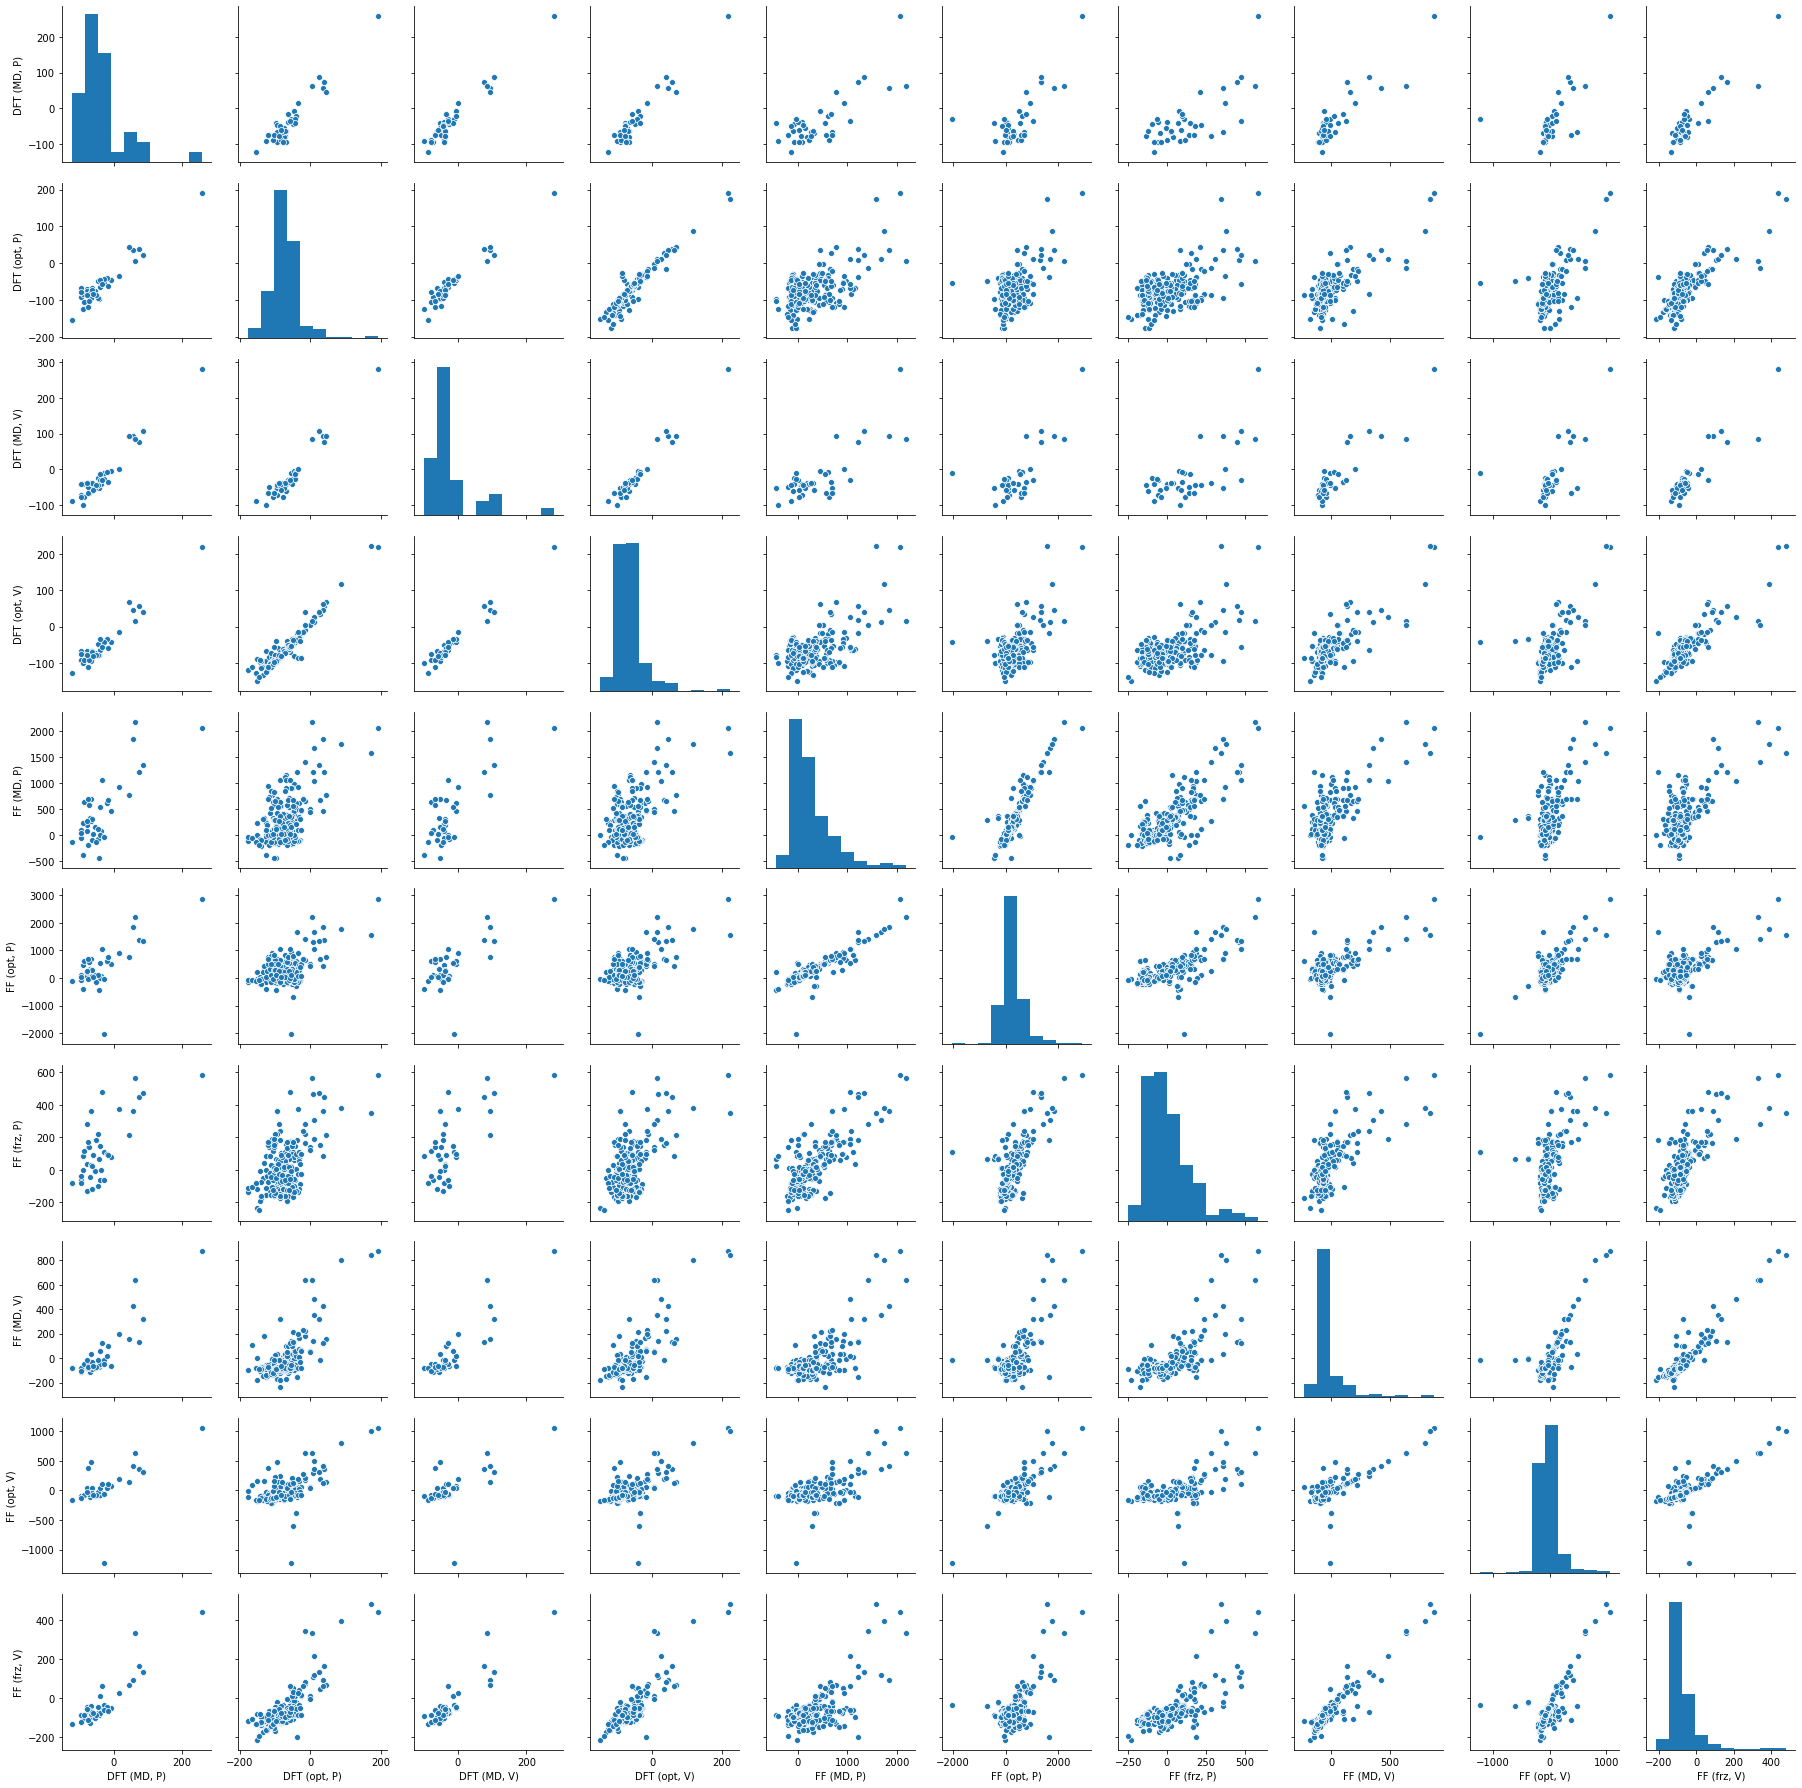

In [5]:
sns.pairplot(scatter_data)
plt.show()

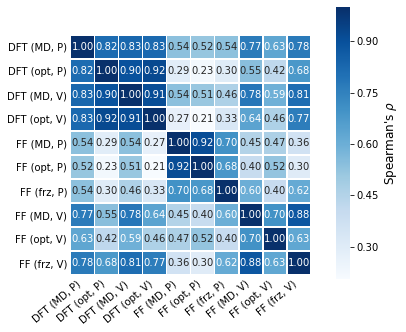

In [6]:
annot_kws = {"fontsize": 10}
grid_kws = {"width_ratios": (.9, .05), "hspace": .3}

fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(5, 5))

sns.heatmap(
    scatter_data.corr(method='spearman'),
    square=True,
    cmap="Blues",
    linecolor='w',
    linewidths=0.5,
    annot=True,
    annot_kws=annot_kws,
    fmt=".2f",
    ax=ax,
    cbar=True,
    cbar_ax=cbar_ax,
)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(length=0)
ax.set_ylim(len(scatter_data.columns), -1)

cbar_ax.set_ylabel("Spearman's $\\rho$", fontsize=12)

plt.show()

## Differences of energies from different optimizers

This section reproduces Fig. 3 of the paper.

In [7]:
opt = pd.read_csv('data/optimizers.csv', index_col=0)

In [8]:
opt.head()

,Framework,Total Energy (kJ/mol Si),Method,Optimizer
ID,,,,
137344551,ABW,198.346707,MD,BFGS + RFO (G < 0.15)
137344551,ABW,187.275831,opt,BFGS + RFO (G < 0.15)
137352475,ABW,187.275832,opt,BFGS + RFO (G < 0.05)
137326395,ABW,187.275831,opt,Lower + RFO
137326395,ABW,199.135694,MD,Lower + RFO


In [9]:
emin = (opt
    .groupby(['Framework', 'Method'])
    .min()['Total Energy (kJ/mol Si)']
    .to_frame()
    .reset_index()
    .pivot(
        index='Framework',
        columns='Method',
        values='Total Energy (kJ/mol Si)',
    )
)

In [10]:
energies = [
    row['Total Energy (kJ/mol Si)']  - emin.loc[row['Framework'], row['Method']]
    for _, row in opt.iterrows()
]
opt['E - Emin (kJ/mol Si)'] = np.array(energies).clip(min=1e-2)

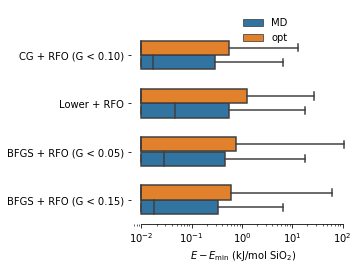

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xscale("log")

sns.boxplot(
    x="E - Emin (kJ/mol Si)",
    y="Optimizer",
    hue="Method",
    data=opt,
    whis=[0, 100],
    width=.6,
    ax=ax,
)

ax.set(ylabel="", xlabel="$E - E_\mathrm{min}$ (kJ/mol SiO$_2$)")
ax.legend(bbox_to_anchor=(0.74, 0.99), frameon=False)
ax.set_ylim(-0.5, 4)
sns.despine(trim=True, left=True)
plt.show()

## Differences of binding energies from different initial conditions

This section reproduces Fig. 4 of the paper.

In [12]:
initial_df = pd.read_csv('data/initial_substrate.csv', index_col=0)

In [13]:
initial_df.head()

,Binding Energy (kJ/mol/OSDA),Host,Guest SMILES,Guests/Cell,Metric,Parent ID,Substrate Theory,Complex
crystal_id,,,,,,,,
137444154,-1249.578876,ACO,NCCN,1,opt,83510401,DFT,"ACO,NCCN"
137371716,-66.284927,ACO,NCCN,2,frz,83510405,DFT,"ACO,NCCN"
137352989,-32.625758,ACO,NCCN,2,MD,83510406,DFT,"ACO,NCCN"
137335164,-326.908102,AEL,CC(C)NC(C)C,1,MD,87639868,DFT,"AEL,CC(C)NC(C)C"
137319294,-157.131315,AEL,CC(C)NC(C)C,2,opt,87639872,DFT,"AEL,CC(C)NC(C)C"


In [14]:
data = (initial_df
    .loc[initial_df['Metric'] == 'opt']
    .pivot(index='Complex', columns='Substrate Theory', values='Binding Energy (kJ/mol/OSDA)')
)

In [15]:
metrics = initial_df['Metric'].unique()

metric_data = {}

for metric in metrics:
    data = (initial_df
        .loc[initial_df['Metric'] == metric]
        .pivot(index='Complex', columns='Substrate Theory', values='Binding Energy (kJ/mol/OSDA)')
        .dropna()
    )
    metric_data[metric] = data

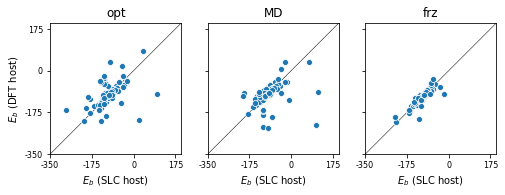

In [16]:
fig, ax_fig = plt.subplots(1, 3, figsize=(8, 6), sharey=True)

lims = np.array([-350, 200])

ticks = np.arange(lims[0], lims[1] + 1, 175)

metrics = ['opt', 'MD', 'frz']

for ax, metric in zip(ax_fig, metrics):
    data = (initial_df
        .loc[initial_df['Metric'] == metric]
        .pivot(index='Complex', columns='Substrate Theory', values='Binding Energy (kJ/mol/OSDA)')
        .dropna()
    )
    
    sns.scatterplot(
        x='SLC',
        y='DFT',
        ax=ax,
        data=data,
    )
    
    ax.plot(
        lims, lims,
        linewidth=0.5,
        color='black',
        zorder=-1,
    )
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ax.get_xticks(), size=8)
    ax.set_yticklabels(ax.get_yticks(), size=8)
    
    ax.set_xlabel('$E_b$ (SLC host)', fontsize=10)
    
    ax.set_title(metric)

ax_fig[0].set_ylabel('$E_b$ (DFT host)', fontsize=10)
plt.show()

## Generating the LaTeX table for the SI

This section generates Tables S2 and S3 of the Supporting Information.

In [39]:
idx_cols = ['Host', 'Guest SMILES', 'Guests/Cell']

ids = bind[['Parent ID'] + idx_cols].drop_duplicates().set_index('Parent ID')
tex = pd.concat([ids, scatter_data], axis=1)

guest_tex = pd.read_csv('data/guests.csv')

tex['Guest ID'] = guest_tex.set_index('Guest SMILES').loc[tex['Guest SMILES']].values
tex = tex.drop('Guest SMILES', axis=1)[['Host', 'Guest ID', 'Guests/Cell'] + idx_order]
tex = tex.sort_values(['Host', 'Guest ID'])

In [40]:
guest_tex.to_latex('SI_guests.tex', index=False)
tex.to_latex('SI_table.tex', index=False, float_format='%.1f', na_rep='-')